In [74]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef

poslabels = ["-%02d" % (i) for i in range(10, 0, -1)] + ["+%02d" % (i) for i in range(1,11)]
# 18 H  17 S  15 E
proplables = ["H%02d" % (i) for i in range(18)] + ["S%02d" % (i) for i in range(17)] + ["E%02d" % (i) for i in range(15)]

cols = ["target"]
for poslabel in poslabels:
    for proplable in proplables:
        cols.append("%s%s" % (poslabel, proplable))
       
# read in data
data_dir="/workspace/chipper_data/chipper-0.3.0-data/"
dtrain = xgb.DMatrix(data_dir + "training_data.ll", feature_names=cols)
dtest = xgb.DMatrix(data_dir + "testing_data.ll", feature_names=cols)

watchlist  = [(dtest,'eval'), (dtrain,'train')]
# specify parameters via map
param = {'n_estimators': 10000, 'max_depth':10, 'objective':'binary:logistic'} #, "eval_metric": "auc"}
num_round = 2000
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=10)
# make prediction
preds = bst.predict(dtest)

[0]	eval-error:0.242788	train-error:0.111977
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	eval-error:0.235577	train-error:0.095295
[2]	eval-error:0.245192	train-error:0.084709
[3]	eval-error:0.204327	train-error:0.077505
[4]	eval-error:0.213942	train-error:0.070167
[5]	eval-error:0.213942	train-error:0.064473
[6]	eval-error:0.209135	train-error:0.058912
[7]	eval-error:0.199519	train-error:0.055989
[8]	eval-error:0.199519	train-error:0.050008
[9]	eval-error:0.204327	train-error:0.045785
[10]	eval-error:0.209135	train-error:0.041065
[11]	eval-error:0.21875	train-error:0.036899
[12]	eval-error:0.21875	train-error:0.03388
[13]	eval-error:0.213942	train-error:0.03195
[14]	eval-error:0.216346	train-error:0.031071
[15]	eval-error:0.209135	train-error:0.027173
[16]	eval-error:0.204327	train-error:0.023924
[17]	eval-error:0.206731	train-error:0.021306
[18]	eval-error:0.204327	train-error:0.

In [30]:
#bst.save_model("/tmp/model.txt")
#bst.dump_model("/tmp/dump.txt")

** Logistic Regression Report, cutoff= 0.27 (MCC=0.615) **
             precision    recall  f1-score   support

        0.0       0.85      0.75      0.79       208
        1.0       0.77      0.87      0.82       208

avg / total       0.81      0.81      0.80       416

LR: sensitivity(recall)=86.5, specificity=74.5, precision=77.3


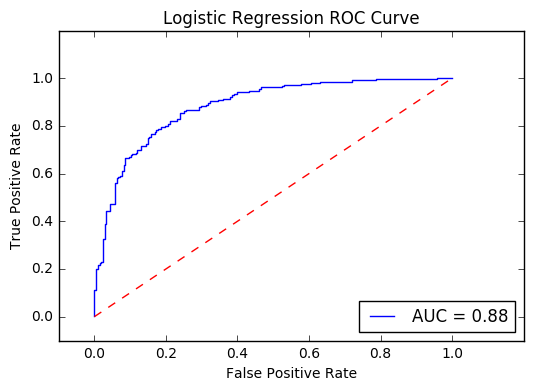

In [75]:
LR_classification_vector = lambda cutoff: [1 if pred >= cutoff else 0 for pred in preds]

def find_best_mcc():
    best_mcc = 0.0
    best_cutoff = 0.0
    for i in range(1, 100):
        pred_cutoff = i/100.0
        mcc = matthews_corrcoef(dtest.get_label(), LR_classification_vector(pred_cutoff))
        if (mcc > best_mcc):
            best_mcc = mcc
            best_cutoff = pred_cutoff
    return (best_cutoff, best_mcc)

(best_cutoff, best_mcc) = find_best_mcc()
print "** Logistic Regression Report, cutoff= %.2f (MCC=%.3f) **" % (best_cutoff, best_mcc)
print classification_report(dtest.get_label(), LR_classification_vector(best_cutoff))


def print_metrics(name, actual, predicted):
    ((tn, fp), (fn, tp)) = confusion_matrix(actual, predicted)
    sensitivity = 100.0 * tp / (tp + fn)
    specificity = 100.0 * tn / (tn + fp)
    precision = 100.0 * tp / (tp + fp)
    print "%s: sensitivity(recall)=%.1f, specificity=%.1f, precision=%.1f" % (name, sensitivity, specificity, precision)

print_metrics("LR", dtest.get_label(), LR_classification_vector(best_cutoff))

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm, metrics

fpr, tpr, thresholds = metrics.roc_curve(dtest.get_label(), preds, pos_label=1)
roc_auc = metrics.roc_auc_score(dtest.get_label(), preds, average='macro', sample_weight=None)
plt.title('Logistic Regression ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% (roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#LR: sensitivity(recall)=77.6, specificity=84.8, precision=86.5

In [77]:
importance = bst.get_score(importance_type="weight")
tuples = [(k, importance[k]) for k in importance]
tuples = sorted(tuples, reverse=True, key=lambda x: x[1])
for (key, value) in tuples:
    print "%5s (%d) %s" % (key, value, "*" * (value/2))

-06H01 (107) *****************************************************
-03E04 (96) ************************************************
-01H00 (95) ***********************************************
-03H01 (90) *********************************************
-04S15 (89) ********************************************
-08H01 (88) ********************************************
-05E01 (88) ********************************************
-02H01 (77) **************************************
-05S09 (77) **************************************
-04H01 (75) *************************************
-06S09 (72) ************************************
-01H01 (72) ************************************
-05H01 (72) ************************************
-08E13 (71) ***********************************
-03S09 (69) **********************************
-09H01 (69) **********************************
-08S09 (68) **********************************
-02S15 (68) **********************************
+02H00 (67) *********************************
-0